In [1]:
from collections import defaultdict
from itertools import product
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from algorithms.linear import LinearRegression
from algorithms.preprocessing import load_and_preprocess_dataset
from algorithms.model_selection import DEFAULT_METRICS
import config

In [2]:
X_train, y_train, X_test, y_test = load_and_preprocess_dataset()

In [3]:
ridge_logs_dir = config.LOGS_DIR / 'ridge'
nn_logs_dir = config.LOGS_DIR / 'nn'
svr_logs_dir = config.LOGS_DIR / 'svr'

In [4]:
ridge_alphas = [1e-2, 5e-3, 1e-3, 5e-4]
ridge_lambdas = [1e-2, 1e-3, 1e-4, 0]
ridge_batch_sizes = [32, 64]

ridge_hyperparams = list(product(ridge_alphas, ridge_lambdas, ridge_batch_sizes))

In [5]:
ridge_scores = []
for alpha, lambda_, batch_size in ridge_hyperparams:
    with open(ridge_logs_dir / f'alpha_{alpha}-lambda_{lambda_}-batch_size_{batch_size}.pkl', 'rb') as f:
        ridge_histories = pickle.load(f)
    ridge_scores.append(ridge_histories)

In [6]:
ridge_last_scores = []

for model in ridge_scores:
    model_last_scores = defaultdict(int)
    for fold in model:
        for metric in DEFAULT_METRICS.keys():
            model_last_scores[f'train_{metric}'] += fold[f'train_{metric}'][-1] / len(model)
            model_last_scores[f'valid_{metric}'] += fold[f'valid_{metric}'][-1] / len(model)
    ridge_last_scores.append(model_last_scores)

In [7]:
valid_ridge = {metric: [ls[f'valid_{metric}'] for ls in ridge_last_scores] for metric in DEFAULT_METRICS.keys()}

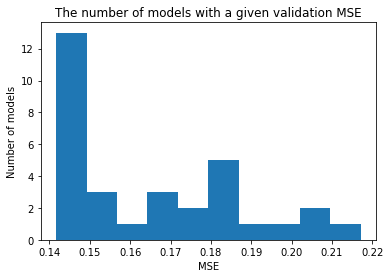

In [8]:
plt.figure()
plt.title('The number of models with a given validation MSE')
plt.xlabel('MSE')
plt.ylabel('Number of models')
plt.hist(valid_ridge['MSE'])
plt.show()

In [9]:
print(np.mean(valid_ridge['MSE']))

0.1646927555636123


In [10]:
ridge_best_score = np.inf
ridge_best_model_index = -1

for i, model in enumerate(ridge_last_scores):
    if model['valid_MAPE'] < ridge_best_score:
        ridge_best_model_index = i
        ridge_best_score = model['valid_MAPE']

In [11]:
for k, v in ridge_last_scores[ridge_best_model_index].items():
    if k.startswith('train'):
        print(k, v)

train_MSE 0.16690228680482844
train_MAE 0.25528346168372146
train_MAPE 2.088003390918025
train_R2 0.8542625335475865


In [12]:
for k, v in ridge_last_scores[ridge_best_model_index].items():
    if k.startswith('valid'):
        print(k, v)

valid_MSE 0.16826969201363326
valid_MAE 0.2536348429874038
valid_MAPE 1.50715105022763
valid_R2 0.833064866522053


In [13]:
print(np.mean(valid_ridge['MSE']), np.std(valid_ridge['MSE']))

0.1646927555636123 0.02203404906150613


In [14]:
mask = [int(lambda_ > 5e-4) for alpha, lambda_, batch_size in ridge_hyperparams]
print(np.sum(np.asarray(valid_ridge['MSE']) * np.asarray(mask)) / np.sum(mask))

0.16335723105879568


In [15]:
mask = [int(batch_size == 64) for alpha, lambda_, batch_size in ridge_hyperparams]
print(np.sum(np.asarray(valid_ridge['MSE']) * np.asarray(mask)) / np.sum(mask))

0.17029704114500047


In [16]:
mask = [int(batch_size == 32) for alpha, lambda_, batch_size in ridge_hyperparams]
print(np.sum(np.asarray(valid_ridge['MSE']) * np.asarray(mask)) / np.sum(mask))

0.15908846998222415


In [17]:
best_model_params = ridge_hyperparams[ridge_best_model_index]
print(best_model_params)

(0.001, 0.001, 64)


In [21]:
best_model = LinearRegression(alpha=0.001, lambda_=0.001)
history = best_model.fit(X_train, y_train, X_test, y_test, epochs=500)

alpha=0.001, lambda=0.001, batch_size=32: 100%|██████████| 500/500 [00:21<00:00, 23.51it/s, train_mse=0.1425293, valid_mse=0.5756633]


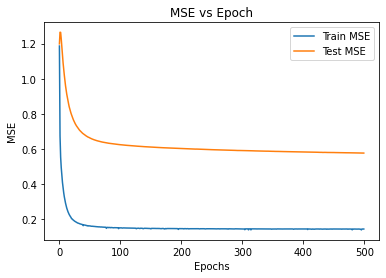

In [34]:
h = pd.DataFrame.from_dict(history)[['train_MSE', 'valid_MSE']]
h = h.set_axis(['Train MSE', 'Test MSE'], axis=1)
h.plot()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MSE vs Epoch')
plt.show()